In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
from slugify import slugify

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df
format_kwargs = dict(precision=2, thousands="'", decimal=",")
def add_table_to_page(table, table_no, caption, section, page, rule: bool = False):
    
    rules = 'Les éléments dont la moyenne des résultats est supérieure à la moyenne du projet sont en rouge.'
    
    if rule:
        caption = f'Table {section}{page}-{table_no}: {caption} {rules}'
    else:
        caption = f'Table {section}{page}-{table_no}: {caption}'
    
    table = table.format_index(str.title, axis=1).format_index(str.title, axis=0).format(**format_kwargs)
    return table.set_caption(caption)
glue('blank_caption', " ", display=False)

new_data = pd.read_csv("data/macro_current.csv")
beach_data = pd.read_csv("data/pstock_beaches_current.csv")

In [2]:
new_data = pd.read_csv("data/macro_current.csv")
beach_data = pd.read_csv("data/pstock_beaches_current.csv")

new_column_names = {
    "Position":"position",
    "Substrat":"substrat",
    "Date":"date",
    "Code":"code",
    "Quantité":"quantite",
    "Aire":"area"
}

length_key = beach_data[["Plage","length"]].drop_duplicates("Plage").set_index("Plage")
work_data = new_data[["Plage", *new_column_names.keys()]].copy()
work_data.rename(columns=new_column_names, inplace=True)
work_data["length"] = work_data.Plage.apply(lambda x: length_key.loc[x, "length"])
work_data["slug"] = work_data.Plage.apply(lambda x: slugify(x))
work_data["echantillon"] = list(zip(work_data.slug, work_data['date']))
work_data['date'] = pd.to_datetime(work_data["date"], format="mixed", dayfirst=True)
work_data.dropna(inplace=True)
work_data[["position", "substrat"]] = work_data[["position", "substrat"]].astype("int")
event_total = work_data.groupby(["echantillon", "Plage", "date", "position", "area"], as_index=False).quantite.sum()
event_total["pcs/m²"] = event_total.quantite/event_total.area

# Macro déchets plage et position

__Résultats agrégés par objet, position et échantillon__

In [3]:
caption = "Les données sont regroupées en deux groupes par échantillon: ligne-d'eau, plage-seche, tous objéts compris."

columns=["Plage", "position", "code", "quantite", "echantillon"]

table_one = work_data[columns][work_data.echantillon == ("amphion", "01.02.2022")].head()
table_one.set_index('code', drop=True, inplace=True)
table_one.index.name = None
t_one = table_one.style.set_table_styles(table_css_styles)

table_no = 1
section = 'A'
page = 3

table_one = add_table_to_page(t_one, table_no, caption, section, page)
glue('a3tablone', table_one, display=True)

,Plage,Position,Quantite,Echantillon
G24,Amphion,1,2,"('amphion', '01.02.2022')"
G24,Amphion,2,42,"('amphion', '01.02.2022')"
G66,Amphion,2,7,"('amphion', '01.02.2022')"
G131,Amphion,2,1,"('amphion', '01.02.2022')"
G31,Amphion,1,2,"('amphion', '01.02.2022')"


## Nombre cumulé d'échantillons et particules par plage

In [4]:
sample_totals = event_total.groupby(["echantillon", "date", "Plage"], as_index=False)["pcs/m²"].sum()
df2 = sample_totals.copy()
value_column = "moyenne"

sample_averages = df2.groupby("Plage", as_index=False).agg({"echantillon": "nunique", "pcs/m²":"mean"})
average_of_sample_totals = df2["pcs/m²"].mean()
sample_averages.rename(columns={"pcs/m²":value_column}, inplace=True)
sample_averages.set_index("Plage", inplace=True, drop=True)
sample_averages.index.name = None

In [5]:
# work_data["particules"] = work_data["compte"]
location_summary = work_data.groupby("Plage", as_index=False).agg({"echantillon": "nunique", "quantite":"sum"})
location_summary["% echantillon"] = location_summary.echantillon/location_summary.echantillon.sum()
location_summary["% quantité"] = location_summary.quantite/location_summary.quantite.sum()
# location_summary.set_index("Plage", inplace=True, drop=True)
df1 = location_summary.copy()
df1.set_index("Plage", inplace=True, drop=True)
df1.index.name = None
a_property =  {'color' : 'red'}
a_property2 = { 'color': 'dodgerblue'}

select_values = df1["% echantillon"] < df1["% quantité"]
test_one = df1.loc[select_values].index


caption1 = "Nombre cumulé d'échantillons et le total par plage."
caption2 = "Les plages où le proportion du comptage est supérieur au proportion des échantillons sont en rouge. Les plages dont la moyenne des résultats est supérieure à la moyenne du projet sont en BLEU."  
caption = f'{caption1} {caption2}'

df1["moyenne"] = df1.index.map(lambda x: sample_averages['moyenne'].loc[x])
select_values2 = df1["moyenne"] > 1.45
test_two = df1[select_values2].index

ttwo = df1.style.set_table_styles(table_css_styles).set_properties(subset=pd.IndexSlice[test_two, ["moyenne"]], **a_property2)
ttwo = ttwo.set_properties(subset = pd.IndexSlice[test_one,["% echantillon", "% quantité"]], **a_property)

table_no += 1

table_two = add_table_to_page(ttwo, table_no, caption, section, page)
glue('a3tabletwo', table_two, display=True)

,Echantillon,Quantite,% Echantillon,% Quantité,Moyenne
Amphion,4,2'459,"0,04","0,09","2,56"
Anthy,4,149,"0,04","0,01","0,32"
Aubonne,4,193,"0,04","0,01","0,34"
Baby Plage,4,1'179,"0,04","0,04","1,05"
Bouveret,4,3'286,"0,04","0,12","4,77"
Clarens,4,1'128,"0,04","0,04","1,85"
Crans,3,21,"0,03","0,00","0,44"
Cully,4,48,"0,04","0,00","0,34"
Excenevex,4,3'931,"0,04","0,14","2,52"
Gland,4,206,"0,04","0,01","2,32"


In [6]:
bar_plots = pd.melt(location_summary, id_vars="Plage", value_vars=["% echantillon", "% quantité"])
fig, ax = plt.subplots()
sns.barplot(data=bar_plots, x="Plage", y="value", hue="variable", ax=ax)
ax.legend(loc="upper left")
ax.tick_params(axis="x", labelrotation=90, labelright=True, labelsize=12 )
glue('fig-A31', fig, display=False)
plt.close()

```{glue:figure} fig-A31
---
name: fig-A31
---
{glue:text}`blank_caption` 
```

In [7]:
attribute_columns = ["Plage", "position", "substrat"]
percent_of_samples = df1.loc[select_values].echantillon.sum()/location_summary.echantillon.sum()
attributes_of_samples = work_data[work_data.Plage.isin(test_one)].drop_duplicates(["Plage"])


def translate_columns(data, columns, keys):
    
    for i, column in enumerate(columns):
        
        data[column] = data[column].apply(lambda x: keys[i][x])
    
    return data

attribute_keys = [name_the_zones, name_the_substrate, frequentation_name, situation_name, name_the_distance]
# caption = "Les plages et leurs attributs où le proportion du comptage est supérieur au proportion des échantillons."    

# # display_df = translate_columns(attributes_of_samples, attribute_columns[2:], attribute_keys)
# table_three = attributes_of_samples[attribute_columns]
# table_three.set_index("Plage", inplace=True, drop=True)
# table_three = table_three.style.set_table_styles(table_css_styles)
# table_no += 1

# add_table_to_page(table_three, table_no, caption, section, page)

## Compte moyen par échantillon et plage

In [8]:
sample_totals = event_total.groupby(["echantillon", "date", "Plage"], as_index=False)["pcs/m²"].sum()
df2 = sample_totals.copy()
value_column = "moyenne"

summary_particuless = sample_totals["pcs/m²"].describe()

t_three =  translate_describe(summary_particuless, "pcs/m²").T.style.set_table_styles(table_css_styles)

table_no += 1
caption = 'Le résumé des résultats du nombre de déchets trouvées par m².'

table_three = add_table_to_page(t_three, table_no, caption, section, page)
glue('a3table3', table_three, display=True)

,Min,25%,50%,75%,Max,Moyenne,Écart-Type
Pcs/M²,"0,05","0,38","0,78","1,89","8,68","1,45","1,69"


In [9]:


# select_values = sample_averages[value_column] > average_of_sample_totals
# test_two = sample_averages.loc[select_values].index
# caption_one = "Nombre cumulé d'échantillons et la moyenne de pcs/m² par plage."
# caption_two = " Les plages dont la moyenne des résultats est supérieur à la moyenne par échantillon du projet sont en rouge."
# caption_three = f"Moyenne du projet: {round(average_of_sample_totals, 2)}"
# caption = f'{caption_one} {caption_two} {caption_three}'

# sa = sample_averages.style.set_table_styles(table_css_styles).set_caption(caption).format(precision=2)
# sa.set_properties(subset = pd.IndexSlice[test_two,[value_column]], **a_property)

In [10]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

sns.scatterplot(data=sample_totals, x="date", y="pcs/m²", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
# ax[0,0].set_ylim(-1, 1500)
ax[0,0].set_title("Total par échantillon", loc="left")

sns.boxplot(data=sample_totals, y="pcs/m²", dodge=False, width=.9, ax=ax[0,1])
# ax[0,1].set_ylim(-1, 1500)
ax[0,1].set_title("boîte de Tukey", loc="left")

sns.histplot(data=sample_totals, x="pcs/m²", ax=ax[1,0], stat="probability", kde=True)
# ax[1,0].set_xlim(-1, 1500)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("probabilité")
ax[1,0].set_title("Histogramme", loc="left")

sns.ecdfplot(data=sample_totals, x="pcs/m²", ax=ax[1,1])
# ax[1,1].set_xlim(-1, 1500)
ax[1,1].set_ylabel("probabilité")
ax[1,1].set_title("Fonction de répartition", loc="left")
plt.tight_layout()

glue('fig-A32', fig, display=False)
plt.close()

```{glue:figure} fig-A32
---
name: fig-A32
---
{glue:text}`blank_caption` 
```

## Comptes moyenne par position 

In [11]:
position_totals = event_total.groupby(["Plage","echantillon","date", "position"], as_index=False)["pcs/m²"].sum()
position_totals["position"] = position_totals.position.apply(lambda x: name_the_zones[x])
# position_totals["objet"] = position_totals.objet.apply(lambda x: particle_groups[x])
df4 = position_totals.groupby(["Plage","position"], as_index=False)["pcs/m²"].mean()

df4 = df4.pivot(index="Plage", columns=["position"])
df4.index.name = None
df4.columns
df4.fillna(0, inplace=True)

def select_a_set_of_values(data, column_one, threshold_data):
    
    return data.loc[data[column_one] > threshold_data]

position_columns = list(name_the_zones.values())
fragment_columns = list(particle_groups.values())

args = [("pcs/m²", x) for x in position_columns]

water_line = select_a_set_of_values(df4, args[0], average_of_sample_totals).index
plage_seche = select_a_set_of_values(df4, args[1], average_of_sample_totals).index

summary_ligne_deau = position_totals[position_totals.position == "ligne-d'eau"]["pcs/m²"].describe()
summary_plage_seche = position_totals[position_totals.position == "plage-seche"]["pcs/m²"].describe()

In [12]:
ligne_deau_display =  translate_describe(summary_ligne_deau, "ligne d'eau")
plage_seche_display =  translate_describe(summary_plage_seche, "plage-seche")

position_summary = pd.concat([ligne_deau_display, plage_seche_display], axis=1).T.style.set_table_styles(table_css_styles)

table_no += 1
caption = "Le résumé des totaux d'échantillons par position sur la plage."

table_five = add_table_to_page(position_summary, table_no, caption, section, page)
glue('table-five', table_five, display=True)

,Min,25%,50%,75%,Max,Moyenne,Écart-Type
Ligne D'Eau,"0,02","0,18","0,38","0,91","7,60","0,84","1,26"
Plage-Seche,"0,01","0,18","0,40","1,08","3,07","0,70","0,74"


In [13]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

d_position = position_totals.copy()

sns.scatterplot(data=d_position, x="date", y="pcs/m²", hue="position", ax=ax[0,0])
ax[0,0].tick_params(labelbottom=False, bottom=False)
# ax[0,0].set_ylim(-1, 1000)
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].legend().remove()

sns.boxplot(data=d_position, x="position", y="pcs/m²", hue="position", dodge=False, width=.9, ax=ax[0,1])
# ax[0,1].set_ylim(-1, 1000)
ax[0,1].set_title("Boîte de Tukey", loc="left")
ax[0,1].set_xlabel("")
ax[0,1].legend().remove()

sns.histplot(data=d_position, x="pcs/m²", hue="position", ax=ax[1,0], multiple="stack", stat="probability", kde=True)
# ax[1,0].set_xlim(-10, 1000)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("probabilité")
ax[1,0].set_title("Histogramme", loc="left")



sns.ecdfplot(data=d_position, x="pcs/m²", hue="position", ax=ax[1,1])
# ax[1,1].set_xlim(-1, 1000)
ax[1,1].set_ylabel("probabilité")
ax[1,1].set_title("Fonction de répartition", loc="left")

plt.tight_layout()

glue('fig-A33', fig, display=False)
plt.close()

```{glue:figure} fig-A33
---
name: fig-A33
---
{glue:text}`blank_caption` 
```

In [14]:
sax = df4.style.set_table_styles(table_css_styles)

caption = "Le résultat moyen de pcs/m² par position."
 
sax = sax.set_properties(subset = pd.IndexSlice[water_line,args[0]], **a_property)
sax = sax.set_properties(subset = pd.IndexSlice[plage_seche,args[1]], **a_property)
table_no += 1
sax = add_table_to_page(sax,table_no, caption, section, page, rule=True)
glue('table-six', sax, display=True)

### Distributions



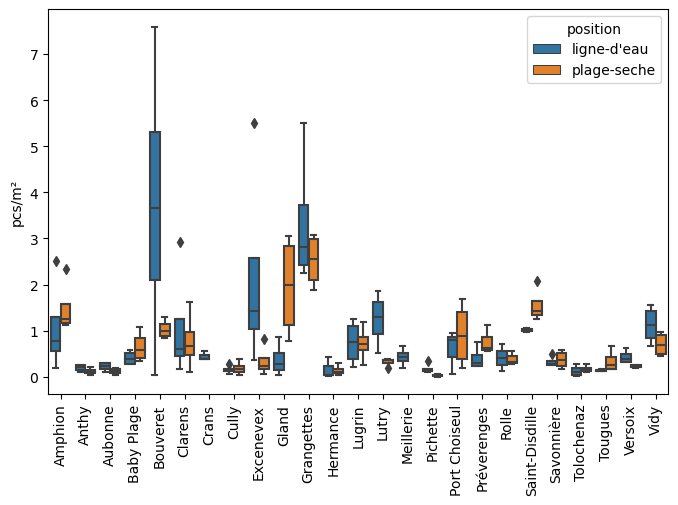

In [15]:
fig, ax = plt.subplots(1, figsize=(8,5))

sns.boxplot(data=position_totals, x="Plage", y="pcs/m²", hue="position", ax=ax)

ax.tick_params(axis="x", labelrotation=90)
ax.set_xlabel("")

plt.show()

In [16]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: main

numpy     : 1.24.2
pandas    : 2.0.0
seaborn   : 0.12.2
matplotlib: 3.7.1

